In [1]:
#Imports das classes criadas
from Classes.Arquivo import Arquivo
from Classes.BancoDados import BancoDados
from Classes.BancoDDL import BancoDDL
from Classes.BancoDML import BancoDML
from Classes.BancoDQL import BancoDQL
from Classes.AnaliseGenero import AnaliseGenero
from Classes.AnaliseArmaFogo import AnaliseArmaFogo
from Classes.AnaliseRegiao import AnaliseRegiao
import plotly.express as px #py -3.12 -m pip install plotly
import pandas as pd

In [3]:
#Carregando todos os CSVs e os inspecionando
try:
    #Criação dos dataframes
    s_total = Arquivo("Arquivos CSV/suicidios-total.csv")
    homens_arma = Arquivo("Arquivos CSV/suicidios-homens-armas-fogo.csv")
    mulheres_arma = Arquivo("Arquivos CSV/suicidios-mulheres-armas-fogo.csv")
    s_homens = Arquivo("Arquivos CSV/suicidios-homens.csv")
    s_mulheres = Arquivo("Arquivos CSV/suicidios-mulheres.csv")
    s_regiao = Arquivo("Arquivos CSV/suicidios-região.csv")

    #Inspeção
    if s_total.verifica and homens_arma.verifica and mulheres_arma.verifica and s_homens.verifica and s_mulheres.verifica and s_regiao.verifica:
        print("Arquivos CSV inspecionados com sucesso!")
    else:
        print(f"""
Status de verificação de cada arquivo:
suicidios-total.csv = {s_total.verifica}
suicidios-homens-armas-fogo.csv = {homens_arma.verifica}
suicidios-mulheres-armas-fogo.csv = {mulheres_arma.verifica}
suicidios-homens.csv = {s_homens.verifica}
suicidios-mulheres.csv = {s_mulheres.verifica}
suicidios-região.csv = {s_regiao.verifica}
        """)
except Exception as e:
    print(f"Erro ao inspecionar o arquivo: {e}")

Arquivos CSV inspecionados com sucesso!


In [4]:
#Abrindo conexão com banco local
BancoLocal = BancoDQL('PPCD_LAW', 'postgres', '123456', 'localhost', '5432')

Conexão bem-sucedida!


In [ ]:
#Criando tabelas no banco local (localhost) PostgresSQL
#CriacaoBanco = BancoDDL('PPCD_LAW', 'postgres', '123456', 'localhost', '5432')
#CriacaoBanco.criacao_tabelas()

In [5]:
#Instanciando DataFrames para usar na inserção dos dados
colunasPeriodo = BancoLocal.buscar_dados('periodo')[['per_cod', 'ano']]
colunasRegiao = BancoLocal.buscar_dados('regiao')[['reg_cod', 'nome']]
regiaoDf = s_regiao.dataframe[['nome', 'período', 'valor']]
mulherFogoDf = mulheres_arma.dataframe[['período', 'valor']]
homemFogoDf = homens_arma.dataframe[['período', 'valor']]

In [ ]:
#Realizando inserção dos dados no banco de dados local
BancoLocalDML = BancoDML('PPCD_LAW', 'postgres', '123456', 'localhost', '5432')
#Table periodo:
#BancoLocalDML.inserir_total(s_total.dataframe)

#Table gen_periodo:
#BancoLocalDML.inserir_gen(s_homens.dataframe, s_mulheres.dataframe, colunasPeriodo)

#Table reg_periodo:
#BancoLocalDML.inserir_reg(colunasRegiao, regiaoDf,  colunasPeriodo)

#Table arma_fogo:
#BancoLocalDML.inserir_dados_fogo(mulherFogoDf, homemFogoDf, colunasPeriodo)
BancoLocalDML.encerrar()

In [6]:
#Gráfico dos gêneros
dadosGeneros = BancoLocal.buscar_dados('gen_periodo')
dadosSuicidiosGeral = s_total.dataframe['valor'].sum() - dadosGeneros['quantidade'].sum()

soma_generos = dadosGeneros.groupby(['gen_cod','descricao','tipo'], as_index=False).sum()
novo_dado = pd.DataFrame({'gen_cod': [3], 'quantidade': [dadosSuicidiosGeral], 'descricao': ['IGN']})
dados_final = pd.concat([soma_generos, novo_dado], ignore_index=True)

analiseGenero = AnaliseGenero(dados_final, 'quantidade', 'descricao', 'quantidade', 'pie')
analiseGenero.criar_grafico()

DataFrame com anos transformados:
   gen_cod  per_cod  quantidade tipo  descricao   ano  quantidade_total
0        1        1        1073    F   Feminino  1989              4491
1        2        1        3417    M  Masculino  1989              4491
2        1        2        1225    F   Feminino  1990              4845
3        2        2        3618    M  Masculino  1990              4845
4        1        3        1202    F   Feminino  1991              5186

Dados filtrados entre 2013 e 2022:
    gen_cod  per_cod  quantidade tipo  descricao   ano  quantidade_total
48        1       25        2223    F   Feminino  2013             10533
49        2       25        8309    M  Masculino  2013             10533
50        1       26        2233    F   Feminino  2014             10653
51        2       26        8419    M  Masculino  2014             10653
52        1       27        2396    F   Feminino  2015             11178

Dados de Homens (gen_cod == 2):
    gen_cod  per_cod  quant

c:\Users\luanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



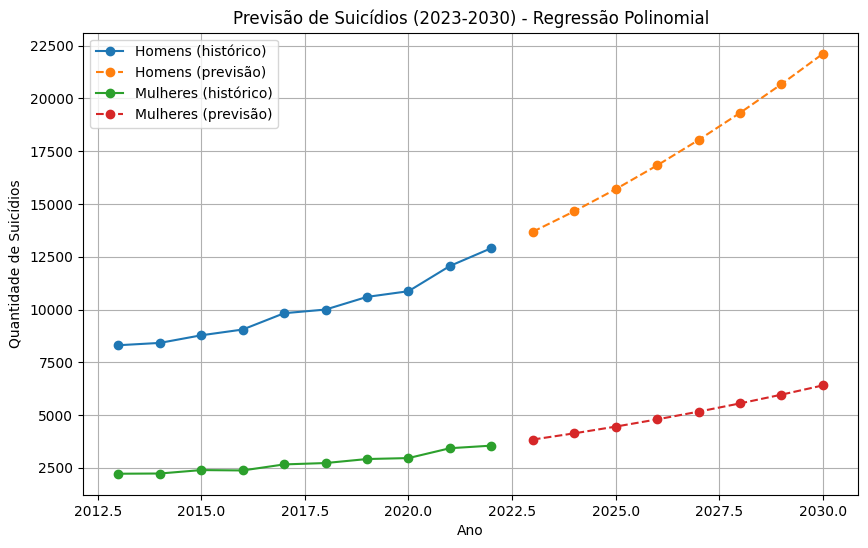

In [7]:
analiseGeneroPoli = AnaliseGenero(dadosGeneros, 'quantidade', 'descricao', 'quantidade', 'pie')
analiseGeneroPoli.modelo_regre_poli()

In [ ]:
dadosArmaFogo = BancoLocal.buscar_dados('arma_fogo')
df = px.data.gapminder()
dadosArmaFogo["size_scaled"] = (dadosArmaFogo["quantidade_total"] - dadosArmaFogo["quantidade_total"].min()) / \
                               (dadosArmaFogo["quantidade_total"].max() - dadosArmaFogo["quantidade_total"].min()) * 50
dadosArmaFogo = dadosArmaFogo.rename(columns={'ano':'Período', 'quantidade_total':'Quantidade'})
analiseArma = AnaliseArmaFogo(dadosArmaFogo, 'Período', 'Quantidade', 'Quantidade')
analiseArma.criar_grafico()

In [ ]:
#vertical bar label por genero por periodo aaaa
dadosGeneros = BancoLocal.buscar_dados('gen_periodo')

dadosGeneros = dadosGeneros.rename(columns={'descricao':'Gêneros', 'quantidade':'Quantidade', 'ano':'Período'})

analiseGeneroPeriodo = AnaliseGenero(dadosGeneros, 'Período', 'Quantidade', 'Gêneros', 'histogram')
analiseGeneroPeriodo.criar_grafico()

In [ ]:
#quantidade por regiao em cada periodo (linegraph) 
dadosRegPeriodo = BancoLocal.buscar_dados('reg_periodo')

dadosRegPeriodo = dadosRegPeriodo.rename(columns={'quantidade':'Quantidade','ano':'Período','descricao':'Descrição'})

analiseRegiaoPeriodo = AnaliseRegiao(dadosRegPeriodo, 'Período', 'Quantidade', 'Descrição')
analiseRegiaoPeriodo.criar_grafico()

In [ ]:
analiseRegiaoPeriodo.anos_max_min()